In [1]:
# general packages
import os, re, yaml
from operator import itemgetter

# scientific packages
import numpy as np
import pandas as pd # to read and work on large datasets
import matplotlib.pyplot as plt

# to allow proper LaTeX formating in figures:
from matplotlib import rc
rc('text', usetex=True)

import mushdynamics as md

In [2]:
folder = "/home/lasbleis-m/Research/output_mush/"

Let's define some useful functions for the figures and calculations (most of them are in the scripts/figures.py) 

In [113]:
regex = re.compile(r'\d+')
def find_float(filename):
    numbers = regex.findall(filename) # gives 2 numbers as number with format "1.05" returns 1 and 05
    return float(numbers[0] + '.' + numbers[1])

def extract_files(subfolder):
        list_files = os.listdir(subfolder)
        timesteps = {}
        for file in list_files:
            if file[-14:] == "statistics.txt":
                file_stat = subfolder + "/" + file
            elif file[-9:] == ".timestep":
                _name = subfolder + "/" + file
                _time = find_float(file)
                timesteps[_name] = _time
            elif file[-5:] == ".yaml":
                with open(subfolder + "/" + file, 'r') as stream:
                    try:
                        param = yaml.safe_load(stream)
                    except yaml.YAMLError as exc:
                        print(exc)
        return file_stat, param, timesteps
    
def diagram(df, ylim=[-2, 2.5], xlim=[-4, 3], N=50):
    """ Build the regime diagram from the data frame df """
    
    x = np.log10(np.array(df["dot_r"].values).astype(float))
    y = np.log10(np.array(df["Ric_adim"].values).astype(float)) # radius IC
    delta = np.log10(np.array(df["delta"].values).astype(float)/np.array(df["Ric_adim"].values).astype(float))
    phi = np.array(df["sum_phi"].values).astype(float) # 
    phir = np.array(df["phi_r"].values).astype(float) # 
    
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=[10, 3])
    cmap = plt.cm.magma
    cntr1 = ax[0].tricontourf(x, y, delta, levels=np.linspace(-4, 4, N),  cmap=cmap)
    cntr2 = ax[1].tricontourf(x, y, phi, levels=np.linspace(0, 0.4, N),  cmap=cmap)
    cbar1 = plt.colorbar(cntr1, ax=ax[0], ticks=np.linspace(-4, 4, 9))
    cbar1.ax.set_ylabel("$\ln_{10}\delta_{ul}/ R_{{ic}}$")
    cbar2 = plt.colorbar(cntr2, ax=ax[1], ticks=[0., 0.1, 0.2, 0.3, 0.4])
    cbar2.ax.set_ylabel(r"$<\phi>$")
    ax[0].set_title("Thickness of upper layer")
    ax[1].set_title("Average porosity")
    ax[0].set_xlabel(r"$\ln_{10}\dot{R}_{{ic}}( \tau_{{ic}})/V_D$")
    ax[0].set_ylabel(r"$\ln_{10}R_{{ic}}/\delta$")
    ax[1].set_xlabel(r"$\ln_{10}\dot{R}_{{ic}}( \tau_{{ic}})/V_D$")
    ax[0].set_ylim(ylim)
    ax[0].set_xlim(xlim)
    return fig, ax


def thickness(phi, R):
    phi_inverse = phi[::-1]
    dr = R[1]-R[0]
    min_phi = np.argmin(phi_inverse)
    phi_inverse = phi_inverse[0:min_phi+1]
    max_value = phi[-1]
    mean_phi = (phi_inverse[-1] + phi_inverse[0])/2
    i_middle = np.argmin(np.abs(phi_inverse-mean_phi))
    if i_middle <5:
        delta = 0.
    else:
        dphi = phi_inverse[1:] - phi_inverse[:-1]
        slope = dphi[i_middle]/dr
        delta = -mean_phi/slope
    return delta


def diagram_data_residual_porosity(folder_main, output="data.csv"):
    """ Extract all the statistics at the end of run
    
    from a folder containing several output folders. 
    """
    
    columns = ["Ric_adim", "tau_ic", "exp", "sum_phi", "delta", "Nmax", "folder", "remarks"]
    df = pd.DataFrame(columns=columns)

    def add_value(df, ric, tau, exp, phi, delta, Nmax, phi_r, phi_t, folder="", remarks=""):
        df_add = pd.DataFrame({"Ric_adim":[ric], "tau_ic":[tau], "exp":[exp], "sum_phi":[phi], "delta":[delta], 
                               "Nmax": Nmax, "phi_r": phi_r, "phi_top": phi_t, "folder":folder, "remarks": remarks})
        df = df.append(df_add)
        return df

    list_subfolder = os.listdir(folder_main)
    print("Looking through folder {}".format(folder_main))
    for subfolder_name in list_subfolder:
        
        
        if os.path.isdir(folder_main + "/" + subfolder_name):
            file_stat, param, timesteps = extract_files(folder_main+"/"+subfolder_name)
        
            data = pd.read_csv(file_stat, sep=" ", index_col=False)
            
            if data["thickness_boundary"].iloc[-1] < 1e-12:
                print("no boundary for R {}, dot_R {}: folder {}".format(param["Ric_adim"], param['coeff_velocity'], folder_main + "/" +subfolder_name))
            elif np.abs(data["radius"].iloc[-1] -param["Ric_adim"])/param["Ric_adim"]>1e-2:
                print("Run not finished for R {}, dot_R {}: folder {}".format(param["Ric_adim"], param['coeff_velocity'], folder_main + "/" +subfolder_name))
                print(data["radius"].iloc[-1], param["Ric_adim"])
            else: 
                try:
                    name_max = max(timesteps.items(), key=itemgetter(1))[0] 
                except: 
                    print(timesteps.items())
                    print(subfolder_name)
                data_max = pd.read_csv(name_max, sep=" ")
                delta = thickness(data_max["porosity"].to_numpy()[:-1], data_max['radius'].to_numpy()[:-1])
                #delta = data["thickness_boundary"].iloc[-1]
                if delta ==0: 
                    print("oups, problem with delta not well defined", param["Ric_adim"], data["thickness_boundary"].iloc[-1])
                index_bottom = abs(data_max['radius'] - 0.05*param["Ric_adim"]).idxmin()
                phi_r = data_max["porosity"].iloc[index_bottom]
                index_top = abs(data_max['radius'] - 0.90*param["Ric_adim"]).idxmin()
                phi_t = data_max["porosity"].iloc[index_top]
                df = add_value(df, param["Ric_adim"], param['time_max'], param['growth_rate_exponent'], 
                                 data["sum_phi"].iloc[-1], delta , 
                                 data["radius_size"].iloc[-1], phi_r, phi_t, folder=subfolder_name)
        else: print("oups, not a folder: {}".format(folder_main + "/" + subfolder_name))

    df["dot_r"] = df["Ric_adim"]/df["tau_ic"]*df["exp"] 
    return df

# Supporting information for "The fate of liquids trapped during the Earth’s inner core growth"


This notebook presents the different figures in the Supporting information of the paper The fate of liquids trapped during the Earth’s inner core growth by Lasbleis, Kervazo and Choblet. 

## Scaling laws presented in the paper

First we select the global data set for the scaling law:

In [114]:
folder = "/home/lasbleis-m/Research/"
values = diagram_data_residual_porosity(folder+"scalinglaw_3/", "diag.csv")
values["logdot_r"]=np.log10(values["dot_r"])
values["logr"]=np.log10(values["Ric_adim"])

print(values.columns)

Looking through folder /home/lasbleis-m/Research/scalinglaw_3/
Run not finished for R 316.22776601683796, dot_R 0.0031622776601683794: folder /home/lasbleis-m/Research/scalinglaw_3//exp_5.00e-01_coeff_3.16e-03_radius_3.16e+02
22.413 316.22776601683796
delta OK
no boundary for R 1000.0, dot_R 0.001: folder /home/lasbleis-m/Research/scalinglaw_3//exp_5.00e-01_coeff_1.00e-03_radius_1.00e+03
oups, problem with delta not well defined 1000.0 0.25351
Run not finished for R 316.22776601683796, dot_R 0.00031622776601683794: folder /home/lasbleis-m/Research/scalinglaw_3//exp_5.00e-01_coeff_3.16e-04_radius_3.16e+02
2.7196 316.22776601683796
oups, problem with delta not well defined 999.9999999999999 0.71433
oups, problem with delta not well defined 316.22776601683796 0.051958000000000004
delta OK
Run not finished for R 1000.0, dot_R 0.03162277660168379: folder /home/lasbleis-m/Research/scalinglaw_3//exp_5.00e-01_coeff_3.16e-02_radius_1.00e+03
218.3 1000.0
no boundary for R 999.9999999999999, dot_

In [120]:
values["dR"] = values["Ric_adim"]/values["Nmax"]


values = values[values["delta"]>0.]
print(values[["Ric_adim", "dR", "delta"]])

     Ric_adim          dR     delta
0  316.227766   0.0316228  0.130503
0   10.000000       0.001  0.125966
0  100.000000        0.01  0.124537
0   31.622777  0.00316228  0.125379
0   31.622777  0.00316228  0.250213
0   10.000000       0.001  0.252457
0   31.622777  0.00316228  0.038010
0   10.000000   0.0009999  0.021287
0   31.622777  0.00316228  0.021259
0  316.227766   0.0316228  0.129749
0  100.000000        0.01  0.067834
0   31.622777  0.00316196  0.125086
0   31.622777  0.00210819  0.007227
0  100.000000        0.01  0.067903
0   31.622777  0.00316228  0.068105
0   31.622777  0.00316228  0.038053
0   31.622777  0.00316228  0.068029
0   10.000000   0.0009999  0.068288
0  316.227766   0.0316228  0.246821
0   31.622777  0.00316228  0.009070
0  100.000000    0.010001  0.040215
0  100.000000        0.01  0.246870
0   31.622777  0.00316228  0.248541
0  316.227766   0.0316228  0.246658
0   31.622777  0.00316228  0.012663
0  100.000000    0.009999  0.246339
0   10.000000   0.0010001  0

### for the linear cases: 

[10000 10001 15000 9999]


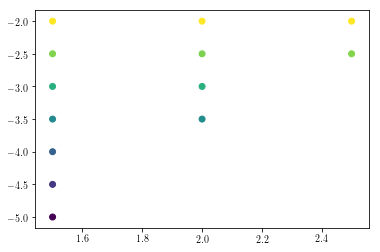

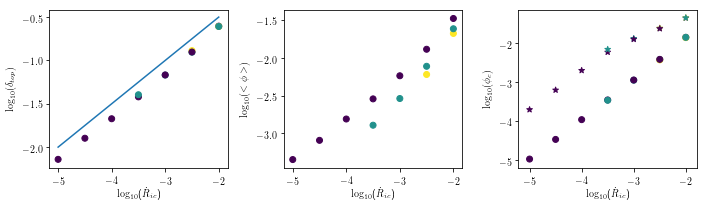

In [121]:
# select data for exp = 1
exp1 = values[values["exp"]==1.]
exp1 = exp1[exp1["logr"]>1]
exp1 = exp1[exp1["logdot_r"]<-1.]

logR = np.log10(exp1["Ric_adim"])
logdot_r = np.log10(exp1["dot_r"])
logdelta = np.log10(exp1["delta"])
logphi = np.log10(exp1["sum_phi"])
logphir = np.log10(exp1["phi_r"])
logphit = np.log10(exp1["phi_top"])
tauic = np.log10(exp1["tau_ic"])

fig, ax = plt.subplots()
ax.scatter(logR, logdot_r, c=logdelta)

fig, ax = plt.subplots(1, 3, figsize=[10, 3])
sc = ax[0].scatter(logdot_r, logdelta, c=logR)
ax[0].plot([-5, -2], [-2, -0.5])
sc = ax[1].scatter(logdot_r, logphi, c=logR)
sc = ax[2].scatter(logdot_r, logphir, c=logR, marker="*")
sc = ax[2].scatter(logdot_r, logphit, c=logR)
ax[0].set_xlabel("$\log_{10}$($\dot R_{{ic}}$)")
ax[0].set_ylabel("$\log_{10}(\delta_{top})$")
ax[1].set_xlabel("$\log_{10}$($\dot R_{{ic}}$)")
ax[1].set_ylabel("$\log_{10}(<\phi>)$")
ax[2].set_ylabel("$\log_{10}(\phi_c)$")
ax[2].set_xlabel("$\log_{10}$($\dot R_{{ic}}$)")
plt.tight_layout()


print(exp1["Nmax"].unique())


10.0 0.021287
10.0 0.021286874180135286
100.0 0.023046
100.0 0.023046393684322184
1000.0 6.627
1000.0 6.627026397255657
31.622776601683793 0.021544
31.622776601683793 0.02125138259001316
316.22776601683796 0.051958000000000004
316.22776601683796 0.05444716326505162


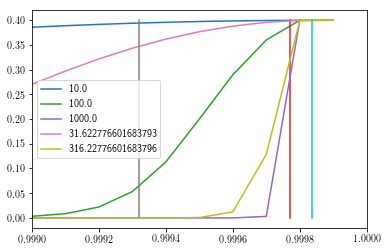

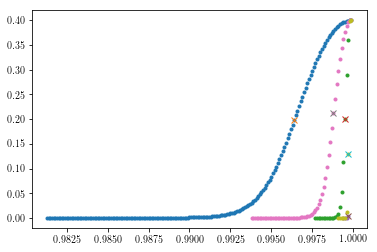

In [87]:
folder_base = "/home/lasbleis-m/Research/test_delta"
folder_list = ["/home/lasbleis-m/Research/test_delta/exp_1.00e+00_coeff_1.00e-04_radius_1.00e+01", 
              "/home/lasbleis-m/Research/test_delta/exp_1.00e+00_coeff_1.00e-04_radius_1.00e+02", 
              "/home/lasbleis-m/Research/test_delta/exp_1.00e+00_coeff_1.00e-04_radius_1.00e+03", 
              "/home/lasbleis-m/Research/test_delta/exp_1.00e+00_coeff_1.00e-04_radius_3.16e+01", 
              "/home/lasbleis-m/Research/test_delta/exp_1.00e+00_coeff_1.00e-04_radius_3.16e+02"]

fig, ax =plt.subplots()
fig1, ax1 =plt.subplots()

for folder in folder_list: 
    file_stat, param, timesteps = extract_files(folder)
    param["dot_r"] = param["Ric_adim"]/param["time_max"]*param["growth_rate_exponent"]
    
    name_max = max(timesteps.items(), key=itemgetter(1))[0]
    data = pd.read_csv(name_max, sep=" ")
    
    ax.plot(data["radius"]/param["Ric_adim"], data["porosity"], label="{}".format(param["Ric_adim"]))
    
    data_stat = pd.read_csv(file_stat, sep=" ", index_col=False)
    delta = data_stat["thickness_boundary"].iloc[-1]
    ax.plot([(1.-delta/param["Ric_adim"]), (1.-delta/param["Ric_adim"])], [0, 0.4])
    print(param["Ric_adim"], delta)
    
    phi = data["porosity"].to_numpy()[:-1]
    
    R = data["radius"].to_numpy()[:-1]
    
    phi_inverse = phi[::-1]
    dr = R[1]-R[0]
    min_phi = np.argmin(phi_inverse)
    phi_inverse = phi_inverse[0:min_phi+1]
    R_inverse = R[::-1]
    
    R_inverse = R_inverse[0:min_phi+1]
    #print(phi_inverse)
    ax1.plot(R_inverse/param["Ric_adim"], phi_inverse, '.')
    max_value = phi[-1]
    mean_phi = (phi_inverse[-1] + phi_inverse[0])/2
    if min_phi <3:
        delta = 0.
    else:
        i_middle = np.argmin(np.abs(phi_inverse-mean_phi))
        ax1.plot(R_inverse[i_middle]/param["Ric_adim"], phi_inverse[i_middle], 'x')
        dphi = phi_inverse[1:] - phi_inverse[:-1]
        slope = dphi[i_middle]/dr
        delta = -mean_phi/slope
    print(param["Ric_adim"], delta)

ax.set_xlim([0.999, 1.00])
ax.legend()

### for the $\sqrt t $ case:

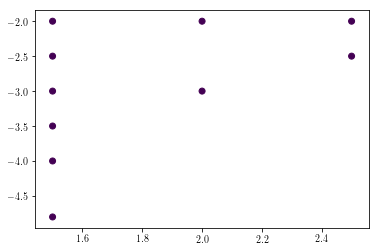

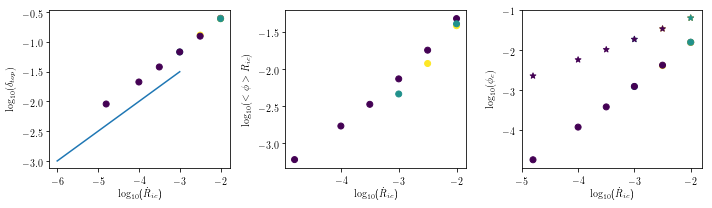

In [122]:
# select data for exp = 1
exp1 = values[values["exp"]==0.5]
exp1 = exp1[exp1["logr"]>1.]
exp1 = exp1[exp1["logdot_r"]<-1.]


logR = np.log10(exp1["Ric_adim"])
logdot_r = np.log10(exp1["dot_r"])
logdelta = np.log10(exp1["delta"])
logphi = np.log10(exp1["sum_phi"])
logphir = np.log10(exp1["phi_r"])
logphit = np.log10(exp1["phi_top"])
tauic = np.log10(exp1["tau_ic"])

fig, ax = plt.subplots()
ax.scatter(logR, logdot_r, c=exp1["Nmax"])


fig, ax =plt.subplots(1, 3, figsize=[10, 3])
sc = ax[0].scatter(logdot_r, logdelta, c=logR)
ax[0].plot([-6, -3], [-3, -1.5])
sc = ax[1].scatter(logdot_r, logphi, c=logR)
sc = ax[2].scatter(logdot_r, logphir, c=logR, marker="*")
sc = ax[2].scatter(logdot_r, logphit, c=logR)
ax[0].set_xlabel("$\log_{10}$($\dot R_{{ic}}$)")
ax[0].set_ylabel("$\log_{10}(\delta_{top})$")
ax[1].set_xlabel("$\log_{10}$($\dot R_{{ic}}$)")
ax[1].set_ylabel("$\log_{10}(<\phi> R_{{ic}})$")
ax[2].set_ylabel("$\log_{10}(\phi_c)$")
ax[2].set_xlabel("$\log_{10}$($\dot R_{{ic}}$)")
plt.tight_layout()

## Diagram for linear or $\sqrt t$ growth

Note that we run less data point for this one, which explains why it is a little bit smoother than the regime in the linear case in the manuscript.

Looking through folder /home/lasbleis-m/Research/output_mush/diag_random_n3_exp05/


/home/lasbleis-m/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


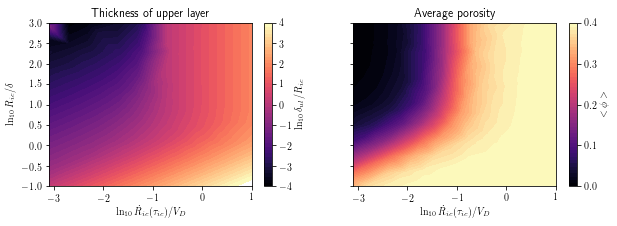

In [25]:
folder_sqrtt = folder + "output_mush/diag_random_n3_exp05/"
df_sqrtt =  diagram_data_residual_porosity(folder_sqrtt, output=folder_sqrtt+"diag_sqrtt.csv")
fig, ax = diagram(df_sqrtt, ylim=[-1, 3], xlim=[-3.1, 1])

## Effect of n=2 or n=3 on the results

The exponent $n$ changes the porosity profile, mostly by changing the average porosity. Overall, it does not change the thickness of the uppermost layer, and does not modify the scaling for the average porosity (but changes the value of the prefactor in the scaling law)

Here are some results for a rather large compaction thickness ($\delta = 0.1R_{ic}$) to highlight the variations:

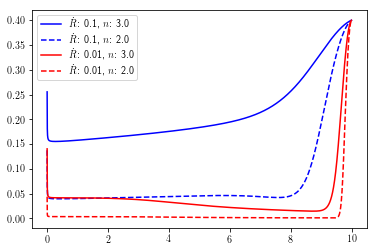

In [4]:
folder_fig = folder+"comparison_n2_n3/"
list_subfolder = os.listdir(folder_fig)

fig, ax = plt.subplots()

for folder_single_run in list_subfolder:
    file_stat, param, timesteps = extract_files(folder_fig+folder_single_run)
    param["dot_r"] = param["Ric_adim"]/param["time_max"]*param["growth_rate_exponent"]
    
    name_max = max(timesteps.items(), key=itemgetter(1))[0]
    data = pd.read_csv(name_max, sep=" ")
    
    marker = ""
    if param["dot_r"] == 0.1:
        marker = marker+"b"
    else: marker = marker+"r"
    if param["n"] == 2:
        marker = marker+ "--"
    
    
    ax.plot(data["radius"], data["porosity"], marker, 
           label=r"$\dot R$: {}, $n$: {}".format(param["dot_r"], param["n"]))

ax.legend()

And the comparisons between the regime diagram for $n=2$ and $n=3$. In the manuscript, we decided to choose $n=3$ to compare with previous results by Sumita 1996.

In [5]:
df_linear_n2 =  diagram_data_residual_porosity(folder+"diag_random_n2/", output="diag_linear_n2.csv")

df_linear_n3 = pd.read_csv("./data/diag_linear.csv")

Looking through folder /home/lasbleis-m/Research/output_mush/diag_random_n2/


/home/lasbleis-m/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


n = 2, similar to Bercovici, Ricard (note that the density of data is not as high as in the main paper)


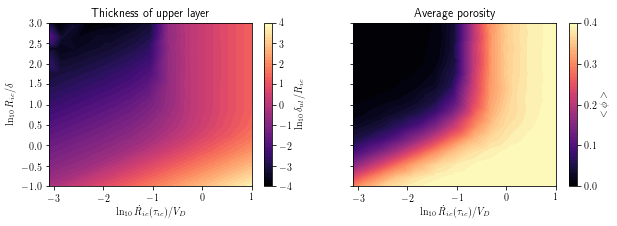

In [6]:
print("n = 2, similar to Bercovici, Ricard (note that the density of data is not as high as in the main paper)")
fig, ax = diagram(df_linear_n2, ylim=[-1, 3], xlim=[-3.1, 1])

n = 3, similar to Sumita, McKenzie, etc.


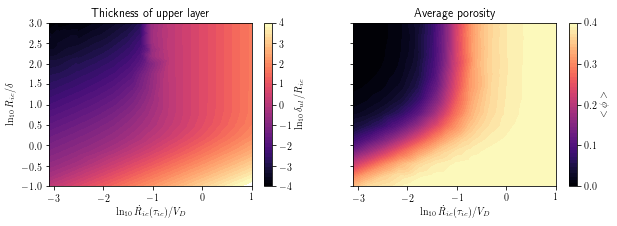

In [7]:
print("n = 3, similar to Sumita, McKenzie, etc. Same than in the manuscript")
fig, ax = diagram(df_linear_n3, ylim=[-1, 3], xlim=[-3.1, 1])

## Different value of phi_0

(0.85, 1.0)

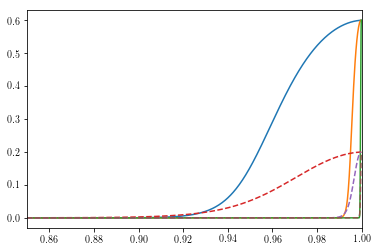

In [132]:
folders_06 = ["/home/lasbleis-m/Research/phi0_06/exp_1.00e+00_coeff_1.00e-01_radius_1.00e+00",
          "/home/lasbleis-m/Research/phi0_06/exp_1.00e+00_coeff_1.00e-01_radius_1.00e+01", 
          "/home/lasbleis-m/Research/phi0_06/exp_1.00e+00_coeff_1.00e-01_radius_1.00e+02"]

folders_02 = ["/home/lasbleis-m/Research/phi0_02/exp_1.00e+00_coeff_1.00e-01_radius_1.00e+00", 
            "/home/lasbleis-m/Research/phi0_02/exp_1.00e+00_coeff_1.00e-01_radius_1.00e+01", 
            "/home/lasbleis-m/Research/phi0_02/exp_1.00e+00_coeff_1.00e-01_radius_1.00e+02"]

folders_02 = ["/home/lasbleis-m/Research/phi0_02/exp_1.00e+00_coeff_1.00e-04_radius_1.00e+00", 
            "/home/lasbleis-m/Research/phi0_02/exp_1.00e+00_coeff_1.00e-04_radius_1.00e+01",
            "/home/lasbleis-m/Research/phi0_02/exp_1.00e+00_coeff_1.00e-04_radius_1.00e+02"]

folders_06 = ["/home/lasbleis-m/Research/phi0_06/exp_1.00e+00_coeff_1.00e-04_radius_1.00e+00", 
            "/home/lasbleis-m/Research/phi0_06/exp_1.00e+00_coeff_1.00e-04_radius_1.00e+01",
            "/home/lasbleis-m/Research/phi0_06/exp_1.00e+00_coeff_1.00e-04_radius_1.00e+02"]


fig, ax = plt.subplots()

for folder_single_run in folders_06:
    file_stat, param, timesteps = extract_files(folder_single_run)
    param["dot_r"] = param["Ric_adim"]/param["time_max"]*param["growth_rate_exponent"]
    
    name_max = max(timesteps.items(), key=itemgetter(1))[0]
    data = pd.read_csv(name_max, sep=" ")
    ax.plot(data["radius"]/param["Ric_adim"], data["porosity"])
    
for folder_single_run in folders_02:
    file_stat, param, timesteps = extract_files(folder_single_run)
    param["dot_r"] = param["Ric_adim"]/param["time_max"]*param["growth_rate_exponent"]
    
    name_max = max(timesteps.items(), key=itemgetter(1))[0]
    data = pd.read_csv(name_max, sep=" ")
    ax.plot(data["radius"]/param["Ric_adim"], data["porosity"], "--")
    
ax.set_xlim([0.85, 1.])